In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import trajeometry
import linetrack
import trajectorybuild
import fuzzylines

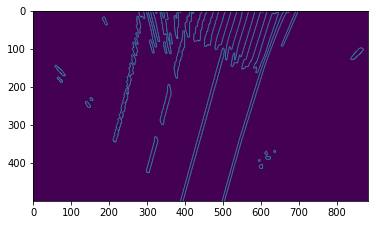

In [2]:
image = cv.imread("../testref-be-binary.png", cv.IMREAD_GRAYSCALE)
plt.imshow(image)

In [3]:
branches = linetrack.extract_branches(image, 1)

In [4]:
func_content = ""
for branch in branches:
    if branch.shape[1] == 1:
        func_content += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(current_branch));\n"

branches_cpp = f"""#include "testref_branches.h"

std::vector<arma::fmat> get_testref_branches() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_branches.cpp", "w") as f:
    f.write(branches_cpp)

with open("../src/trajectory/test/testref_branches.h", "w") as f:
    f.write("""#ifndef _TEST_TESTREF_BRANCHES
#define _TEST_TESTREF_BRANCHES
#include <vector>
#include <armadillo>

std::vector<arma::fmat> get_testref_branches();

#endif""")

In [5]:
resampled = [trajeometry.resample_curve(branch.astype(float), 10) for branch in branches]

In [6]:
func_content = ""
for branch in resampled:
    if branch.shape[1] == 1:
        func_content += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(current_branch));\n"


resample_cpp = f"""#include "testref_resample.h"

std::vector<arma::fmat> get_testref_resample() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_resample.cpp", "w") as f:
    f.write(resample_cpp)

with open("../src/trajectory/test/testref_resample.h", "w") as f:
    f.write("""#ifndef _TEST_TESTREF_RESAMPLE
#define _TEST_TESTREF_RESAMPLE
#include <vector>
#include <armadillo>

constexpr float _resample_step = 10;
std::vector<arma::fmat> get_testref_resample();

#endif""")

In [7]:
savgol = [trajeometry.savgol_filter(branch, trajeometry.savgol_window(7, branch.shape[1]), 2) if branch.shape[1] > 3 else None for branch in resampled]

In [8]:
func_content = ""
for branch in savgol:
    if branch is None:
        func_content += f"\tcurrent_branch = arma::fmat();\n"
    elif branch.shape[1] == 1:
        func_content += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(current_branch));\n"


savgol_cpp = f"""#include "testref_savgol.h"

std::vector<arma::fmat> get_testref_savgol() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_savgol.cpp", "w") as f:
    f.write(savgol_cpp)

with open("../src/trajectory/test/testref_savgol.h", "w") as f:
    f.write("""#ifndef _TEST_TESTREF_SAVGOL
#define _TEST_TESTREF_SAVGOL
#include <vector>
#include <armadillo>

constexpr float _savgol_window = 7;
constexpr float _savgol_degree = 2;
std::vector<arma::fmat> get_testref_savgol();

#endif""")

In [9]:
lengths = [np.sum(np.linalg.norm(np.diff(branch.astype(np.float32)), axis=0)) for branch in branches]

In [10]:
lengths = []
for branch in branches:
    result = np.float32(0)
    for i in range(branch.shape[1] - 1):
        norm = np.float32(np.linalg.norm(np.float64(branch[:, i + 1]) - np.float32(branch[:, i])))
        result = np.float32(result + norm)
    lengths.append(result)


content = ",".join(map(str, lengths))

lengths_cpp = f"""#include "testref_length.h"

std::vector<float> get_testref_length() {{
    std::vector<float> lengths = {{{content}}};
    return lengths;
}}"""

with open("../src/trajectory/test/testref_length.cpp", "w") as f:
    f.write(lengths_cpp)

with open("../src/trajectory/test/testref_length.h", "w") as f:
    f.write("""#ifndef _TEST_TESTREF_LENGTH
#define _TEST_TESTREF_LENGTH
#include <vector>

std::vector<float> get_testref_length();

#endif""")

In [11]:
scale_factor = (21.8 - 4.8) / 500
cut = [linetrack.cut_line_angles(branch.astype(float), 9, 1, 2, 8, 1*scale_factor) for branch in savgol if branch is not None]



0.023112462878633083
0.023121215174835022
0.02343706510364064
0.027800711946487214
0.05316828612667691
0.11469927895905131
0.15611292570480226
0.121015786255086


7.616802128189281e-05
7.634372836421621e-05
8.198781567836562e-05
0.00014734983136962374
0.00040320322295647813
0.0007174942519950095
0.0010053013028330556
0.0015849511119244092
0.0018875320082313643
0.0023557831674791184
0.007137643976891994
0.029753150007016355
0.10288165890352974
0.20608677556539468
0.21294666823641975
0.10998738297879607
0.030070907031730296
0.006418334409568596
0.002329516845490093
0.0020659408916555264
0.0018566574773229523
0.0020077472456331
0.0028258581970730533


0.0008035661650236482
0.0008037711775425616
0.0008102500012606916
0.0008830758981026117
0.0011414832029298647
0.0013469386675553673
0.001465549346289323
0.0020197475102384896
0.003049130073881938
0.010278079633202843
0.053914175984474
0.1822496868762795
0.28062375497138237
0.18104795739269486
0.053642877662909955
0.011171137847611796
0.003

In [12]:
func_content = ""
i = 0
for cuts in cut:
    cutlist = []
    for branch in cuts:
        cutlist.append(i)
        if branch is None:
            func_content += f"\tarma::fmat branch{i} = arma::fmat();\n"
        elif branch.shape[1] == 1:
            func_content += f"\tarma::fmat branch{i} = arma::fmat(2, 1);\n"
            func_content += f"\tbranch{i}(0, 0) = {branch[0, 0]};\n"
            func_content += f"\tbranch{i}(1, 0) = {branch[1, 0]};\n"
        else:
            func_content += f"\tarma::fmat branch{i} = {{{{{','.join(map(str, branch[0]))},}},\n"
            func_content += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
        i += 1
    func_content += f"\tcuts = {{{', '.join('std::move(branch' + str(i) + ')' for i in cutlist)}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(cuts));\n"


cut_cpp = f"""#include "testref_cut_angles.h"

std::vector<std::vector<arma::fmat>> get_testref_cut_angles() {{
    std::vector<std::vector<arma::fmat>> branches;
    std::vector<arma::fmat> cuts;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_cut_angles.cpp", "w") as f:
    f.write(cut_cpp)

with open("../src/trajectory/test/testref_cut_angles.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_CUT_ANGLES
#define _TEST_TESTREF_CUT_ANGLES
#include <vector>
#include <armadillo>

constexpr int _filter_size = 9;
constexpr float _filter_deviation = 1;
constexpr float _min_branch_length = 8;
constexpr int _min_branch_size = 2;
constexpr float _max_curvature = {1*scale_factor};
std::vector<std::vector<arma::fmat>> get_testref_cut_angles();

#endif""")

In [13]:
filtered = linetrack.filter_lines([branch.astype(float) for branch in branches],
  savgol_degree = 2,                                         # Savitzky-Golay filter polynomial degree
  initial_filter_window = 5,                                 # Savitzky-Golay window width of the first filter applied to curves before any further processing
  smoothing_filter_window = 9,                               # Savitzky-Golay window width of the filter last applied to final detected curves
  branch_step = 10,                                          # Resampling distance applied before any further processing, in pixels
  min_branch_length = 8,                                     # Curves that are shorter than this length in pixels are discarded right away
  min_line_length = 35,                                      # Curves that are shorter than this length in pixels after all processing is done are discarded
  max_curvature = 1*scale_factor,                            # Curve sections that have a curvature sharper than this in rad/m are split
  curvature_filter_size = 9,                                 # Size of the gaussian filter applied to curvature to smooth out noise in the local curvature values
  curvature_filter_deviation = 1,                            # Standard deviation of the gaussian filter applied to curvature values
  merge_max_distance = 140,                                  # Curves that are farther away than this distance in pixels from each other can not be merged
  estimate_start = 1,                                        # Index of the first point relative to a curve extremity to consider for merger estimation
  estimate_end = 8,                                          # Index of the last point relative to a curve extremity to consider for merger estimation
  max_angle_diff = 0.86,                                     # Curves whose extremity vectors have an angle difference higher than this value in radians can not be merged
  max_rmse = 2,                                              # Curves under this Root Mean Squared Error value are merged
)                              



0.023112462878633083
0.023121215174835022
0.02343706510364064
0.027800711946487214
0.05316828612667691
0.11469927895905131
0.15611292570480226
0.121015786255086


0.001000401687558074
0.0010005200098946719
0.0010048192770629502
0.0010649798671506048
0.0014259626388294945
0.0023799365648045304
0.0032674553095216213
0.0030662184998346124
0.0028288985683439212
0.0032366781606581172
0.005597570199134681
0.023410596124135326
0.08164794945152712
0.16198919353935753
0.17023440794892172
0.09042388391890488
0.02479850835411532
0.005521506795219151
0.0031010718412165963
0.0026761531191914624
0.002774000211126519
0.0025484444858091147
0.0015475433179602178


0.0005022189475923239
0.0005024174772496101
0.0005092021958072705
0.0005959180865399388
0.0010285164201355565
0.0018665778808387146
0.002284864629555972
0.0020141884224400886
0.0025613575096890217
0.007919904048112384
0.039583087381692875
0.13460013722992678
0.20939921334755565
0.1374957055481337
0.04153575524026878
0.007841234420606958
0.0

0.012525460050024813
0.01161919328113602
0.008069595228299168
0.008051889232642374
0.011379962046175475


0.06345255123628793
0.06348684065146895
0.06460171884870304
0.07775184195442832
0.13142530500286645
0.19633837472983473
0.19683410126556064


0.008646901669822127
0.008646700532650464
0.008639441347151467
0.008538283379811475
0.007926552129881016
0.0061611396894158095
0.0036059468694178247
0.0016805570552745766
0.0010727502395307532
0.001759591947606083
0.005833097540638353
0.02638793363675483
0.0827080292025384
0.14633359987489197
0.1425090436927492
0.07779500150440725
0.026185115964040877
0.00790452411198668
0.004240756117540537
0.0035923429272079715
0.0037627699584177887
0.007769892316156093
0.01759932797116545
0.027259132073231794


0.1886359543001859
0.18864736316818403
0.18902517298827928
0.1936278388398841
0.21425555608143956
0.24826491226357986


0.2274298334407655
0.2274277135440101
0.22735751220484837
0.22650228481447732
0.22266942156639752
0.21635009840160357


In [14]:
func_content = ""
for branch in filtered:
    if branch.shape[1] == 1:
        func_content += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content += f"\t                   {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(current_branch));\n"

filter_lines_cpp = f"""#include "testref_filter_lines.h"

std::vector<arma::fmat> get_testref_filter_lines() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_filter_lines.cpp", "w") as f:
    f.write(filter_lines_cpp)

with open("../src/trajectory/test/testref_filter_lines.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_FILTER_LINES
#define _TEST_TESTREF_FILTER_LINES
#include <vector>
#include <armadillo>

constexpr float _scale_factor = {scale_factor};
std::vector<arma::fmat> get_testref_filter_lines();

#endif""")


In [15]:
from sklearn.neighbors import KernelDensity

def estimate_main_angle(lines):
    # First get the local angles of each discrete curve segment
    angles = []
    for line in lines:
        # Filter out the points that are not in the "local area" of estimation
        local_filter = ((-5 < line[0]) & (line[0] < 5) &
                        (0 < line[1]) & (line[1] < 10))
        # Less than a segment remaining
        if local_filter.sum() < 2:
            continue

        line_angles = np.arctan2(np.gradient(line[1, local_filter]), np.gradient(line[0, local_filter]))
        angles.append(line_angles)

    # No data to estimate from : just assume π/2 (straight ahead)
    if len(angles) == 0:
        return np.pi/2
    angles = np.concatenate(angles, axis=0)
    print(angles)

    # Remove the angles that are a tad too extreme
    angles = angles[(0.43 < angles) & (angles < np.pi - 0.43)]
    if angles.size == 0:
        return np.pi/2

    # Return the angle of maximal density among the extracted angles
    density_model = KernelDensity(kernel="epanechnikov", bandwidth=0.1)
    density_model.fit(angles.reshape(-1, 1))
    angle_density = density_model.score_samples(angles.reshape(-1, 1))
    return angles[np.argmax(angle_density)]

filtered_target = [line.copy() for line in filtered]
for i, line in enumerate(filtered_target):
    line[0] = line[0] * scale_factor - 15;
    line[1] = (500 - line[1]) * scale_factor + 4.8;
    if line[1, 0] > line[1, -1]:
        line = np.flip(line, axis=1)
    filtered_target[i] = line

main_angle = estimate_main_angle(filtered_target)
main_angle

[1.29714921 1.29480164 1.29143559 1.2904624  1.2913821  1.29499057
 1.29948979 1.30182452 1.30109081 1.30014618 1.30016317 1.30111474
 1.30310335 1.30198468 1.30017062 1.29281473 1.29343587 1.29604676
 1.29850289 1.30025468 1.30112458 1.30063672 1.2963298  1.29307628
 1.29194625 1.29022037 1.29123994 1.29329938 1.29218937 1.28965418
 1.31080334 1.30729532 1.30247559 1.30181353 1.30259646 1.30238303
 1.30215801 1.30622571 1.30740763 1.30227743 1.29850711 1.29948888
 1.30011633 1.29961102 1.3008638  1.3048098  1.30456177 1.3029039
 1.30035519 1.2988477  1.29832826 1.29745157 1.2968431  1.29774327
 1.29922202 1.30015478 1.29800263 1.29499724 1.29337893 1.29237717
 1.3063802  1.30605158 1.3030482  1.306206   1.32338402 1.33473862
 1.2938419  1.29136426 1.27896165 1.28691847 1.3351869  1.38018577
 1.39463443]


1.3021580052236297

In [16]:
func_content = ""
for branch in filtered_target:
    if branch.shape[1] == 1:
        func_content += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(current_branch));\n"

filtered_target_cpp = f"""#include "testref_filtered_target.h"

std::vector<arma::fmat> get_testref_filtered_target() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_filtered_target.cpp", "w") as f:
    f.write(filtered_target_cpp)

with open("../src/trajectory/test/testref_filtered_target.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_FILTERED_TARGET
#define _TEST_TESTREF_FILTERED_TARGET
#include <vector>
#include <armadillo>

constexpr float _main_angle = {main_angle};
std::vector<arma::fmat> get_testref_filtered_target();

#endif""")

In [17]:
gradients = [np.asarray([np.gradient(branch[0]), np.gradient(branch[1])]) for branch in filtered_target]

In [18]:
func_content = ""
for branch in gradients:
    if branch.shape[1] == 1:
        func_content += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content += f"\tbranches.emplace_back(std::move(current_branch));\n"

gradient_cpp = f"""#include "testref_gradient.h"

std::vector<arma::fmat> get_testref_gradient() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content}
    return branches;
}}"""

with open("../src/trajectory/test/testref_gradient.cpp", "w") as f:
    f.write(gradient_cpp)

with open("../src/trajectory/test/testref_gradient.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_GRADIENT
#define _TEST_TESTREF_GRADIENT
#include <vector>
#include <armadillo>

std::vector<arma::fmat> get_testref_gradient();

#endif""")

In [19]:
parameters = trajectorybuild.line_parameters(filtered_target, 3.5, main_angle, (4.8 + 10) / 2, 0.5)
print(parameters[5])

[[       inf 0.02771628 0.03153921 ... 0.4700023         inf        inf]
 [0.02771628        inf 0.01835469 ... 0.49619371        inf        inf]
 [0.03153921 0.01835469        inf ...        inf        inf        inf]
 ...
 [0.4700023  0.49619371        inf ...        inf 0.17896371 0.09220274]
 [       inf        inf        inf ... 0.17896371        inf 0.10663373]
 [       inf        inf        inf ... 0.09220274 0.10663373        inf]]


In [20]:
parallel_distance = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in parameters[4])
parallel_angle = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in parameters[5])

parameters_cpp = f"""#include "testref_fuzzy_parameters.h"

std::tuple<arma::fvec, arma::fvec, arma::fvec, arma::fvec, arma::fmat, arma::fmat> get_testref_fuzzy_parameters() {{
    arma::fvec forward_distance = {{{','.join(map(str, parameters[0]))}}};
    arma::fvec left_line_distance = {{{','.join(map(str, parameters[1]))}}};
    arma::fvec right_line_distance = {{{','.join(map(str, parameters[2]))}}};
    arma::fvec line_length = {{{','.join(map(str, parameters[3]))}}};
    arma::fmat parallel_distance = {{{parallel_distance}}};
    arma::fmat parallel_angle = {{{parallel_angle}}};
    return {{forward_distance, left_line_distance, right_line_distance, line_length, parallel_distance, parallel_angle}};
}}""".replace("inf", "arma::fdatum::inf")

with open("../src/trajectory/test/testref_fuzzy_parameters.cpp", "w") as f:
    f.write(parameters_cpp)

with open("../src/trajectory/test/testref_fuzzy_parameters.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_FUZZY_PARAMETERS
#define _TEST_TESTREF_FUZZY_PARAMETERS
#include <tuple>
#include <armadillo>

constexpr float _lane_width = 3.5;
constexpr float _main_angle_distance = {(4.8 + 10) / 2};
constexpr float _vertical_angle_tolerance = 0.5;
std::tuple<arma::fvec, arma::fvec, arma::fvec, arma::fvec, arma::fmat, arma::fmat> get_testref_fuzzy_parameters();

#endif""")

In [21]:
line_sizes = np.asarray([branch.shape[1] for branch in filtered_target])
order = np.argsort(line_sizes)
projection_source = filtered_target[order[-1]]
projection_dest = filtered_target[order[-2]]
projections = [trajeometry.project_on_curve_index(projection_source[:, i], projection_dest) for i in range(projection_source.shape[1])]

In [22]:
vector_content = "\n".join(f"""\tcurrent_projection = {{{','.join(map(str, projection))}}};
\tprojections.push_back(std::move(current_projection));""" for projection in projections)

project_cpp = f"""#include "testref_project_point.h"

std::tuple<arma::fmat, arma::fmat> get_testref_projection_curves() {{
    arma::fmat projection_dest = {{{{{','.join(map(str, projection_dest[0]))}}},
                                   {{{','.join(map(str, projection_dest[1]))}}}}};
    arma::fmat projection_source = {{{{{','.join(map(str, projection_source[0]))}}},
                                     {{{','.join(map(str, projection_source[1]))}}}}};
    return {{projection_source, projection_dest}};
}}

std::vector<std::tuple<int, float>> get_testref_projection_results() {{
    std::vector<std::tuple<int, float>> projections;
    std::tuple<int, float> current_projection;
    {vector_content.replace('None', '-1')}
    return projections;
}}"""

with open("../src/trajectory/test/testref_project_point.cpp", "w") as f:
    f.write(project_cpp)

with open("../src/trajectory/test/testref_project_point.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_PROJECT_POINT
#define _TEST_TESTREF_PROJECT_POINT
#include <tuple>
#include <vector>
#include <armadillo>

std::tuple<arma::fmat, arma::fmat> get_testref_projection_curves();
std::vector<std::tuple<int, float>> get_testref_projection_results();

#endif""")

In [23]:
angles = [trajeometry.vector_angle(projection_dest[:, i], projection_dest[:, i+1]) for i in range(projection_dest.shape[1] - 1)]
#angles = [np.arccos(np.dot(projection_dest[:, i].astype(np.float32), projection_dest[:, i+1].astype(np.float32)) / (np.linalg.norm(projection_dest[:, i].astype(np.float32)) * np.linalg.norm(projection_dest[:, i+1].astype(np.float32)))) for i in range(projection_dest.shape[1] - 1)]

In [24]:
angles_cpp = f"""#include "testref_vector_angle.h"

arma::fmat get_testref_vector_angle_curve() {{
    arma::fmat projection_dest = {{{{{','.join(map(str, projection_dest[0]))}}},
                                   {{{','.join(map(str, projection_dest[1]))}}}}};
    return projection_dest;
}}


std::vector<float> get_testref_vector_angle() {{
    std::vector<float> angles = {{{','.join(map(str, angles))}}};
    return angles;
}}"""

with open("../src/trajectory/test/testref_vector_angle.cpp", "w") as f:
    f.write(angles_cpp)

with open("../src/trajectory/test/testref_vector_angle.h", "w") as f:
    f.write("""#ifndef _TEST_TESTREF_VECTOR_ANGLE
#define _TEST_TESTREF_VECTOR_ANGLE
#include <vector>
#include <armadillo>

std::vector<float> get_testref_vector_angle();
arma::fmat get_testref_vector_angle_curve();

#endif""")

In [25]:
system = fuzzylines.FuzzySystem(
    np.asarray([[4.8, 10.8, 21.8], [0, 0.5, 2], [10, 5, 0.0], [0, 0.3, 1], [0, 0.51, 1.24]]),
    np.asarray([[0, -1, -3], [0, -2, -3], [0, -1, -2], [0, -2, -5], [0, -1, -5]]),
    np.asarray([0, 0.25, 0.5, 0.8, 1]),
    4
)

FD_columns, FD_rows = np.meshgrid(parameters[0], parameters[0])
LD_columns, LD_rows = np.meshgrid(parameters[1], parameters[1])
RD_columns, RD_rows = np.meshgrid(parameters[2], parameters[2])
LL_columns, LL_rows = np.meshgrid(parameters[3], parameters[3])
lane_variables = np.asarray(((FD_columns + FD_rows) / 2,
                             np.minimum(np.maximum(LD_columns, RD_rows), np.maximum(RD_columns, LD_rows)),
                             (LL_columns + LL_rows) / 2,
                             parameters[4],
                             parameters[5]))
        
scores = system.fuzzy_scores(lane_variables)
scores

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.2843277,
        0.3934365],
       [0.       , 0.       , 0.       , ..., 0.2843277, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.3934365, 0.       ,
        0.       ]])

In [26]:
FD = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in lane_variables[0])
LD = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in lane_variables[1])
LL = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in lane_variables[2])
PD = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in lane_variables[3])
PA = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in lane_variables[4])
score_content = ",\n".join(f"{{{','.join(map(str, row))}}}" for row in scores)

scores_cpp = f"""#include "testref_fuzzy_scores.h"

arma::fcube get_testref_fuzzy_variables() {{
    arma::fcube variables({lane_variables.shape[1]}, {lane_variables.shape[2]}, {lane_variables.shape[0]});
    variables.slice(0) = {{{FD}}};
    variables.slice(1) = {{{LD}}};
    variables.slice(2) = {{{LL}}};
    variables.slice(3) = {{{PD}}};
    variables.slice(4) = {{{PA}}};
    return variables;
}}

arma::fmat get_testref_fuzzy_scores() {{
    arma::fmat scores = {{{score_content}}};
    return scores;
}}

""".replace("inf", "arma::fdatum::inf")

with open("../src/trajectory/test/testref_fuzzy_scores.cpp", "w") as f:
    f.write(scores_cpp)

with open("../src/trajectory/test/testref_fuzzy_scores.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_FUZZY_SCORES
#define _TEST_TESTREF_FUZZY_SCORES
#include <tuple>
#include <armadillo>

arma::fcube get_testref_fuzzy_variables();
arma::fmat get_testref_fuzzy_scores();

#endif""")

In [27]:
left_dilated = [trajeometry.dilate_curve(curve, 3.5/2, -1) for curve in filtered_target]
right_dilated = [trajeometry.dilate_curve(curve, 3.5/2, 1) for curve in filtered_target]

In [28]:
func_content_left = ""
func_content_right = ""
for branch in left_dilated:
    if branch.shape[1] == 1:
        func_content_left += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content_left += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content_left += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content_left += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content_left += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content_left += f"\tbranches.emplace_back(std::move(current_branch));\n"
for branch in right_dilated:
    if branch.shape[1] == 1:
        func_content_right += f"\tcurrent_branch = arma::fmat(2, 1);\n"
        func_content_right += f"\tcurrent_branch(0, 0) = {branch[0, 0]};\n"
        func_content_right += f"\tcurrent_branch(1, 0) = {branch[1, 0]};\n"
    else:
        func_content_right += f"\tcurrent_branch = {{{{{','.join(map(str, branch[0]))},}},\n"
        func_content_right += f"\t                  {{{','.join(map(str, branch[1]))},}}}};\n"
    func_content_right += f"\tbranches.emplace_back(std::move(current_branch));\n"

dilate_cpp = f"""#include "testref_dilate.h"

std::vector<arma::fmat> get_testref_dilate_left() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content_left}
    return branches;
}}

std::vector<arma::fmat> get_testref_dilate_right() {{
    std::vector<arma::fmat> branches;
    arma::fmat current_branch;
{func_content_right}
    return branches;
}}
"""

with open("../src/trajectory/test/testref_dilate.cpp", "w") as f:
    f.write(dilate_cpp)

with open("../src/trajectory/test/testref_dilate.h", "w") as f:
    f.write(f"""#ifndef _TEST_TESTREF_DILATE
#define _TEST_TESTREF_DILATE

#include <vector> 
#include <armadillo>

constexpr float _dilation = {3.5/2};
constexpr int _left_direction = -1;
constexpr int _right_direction = 1;
std::vector<arma::fmat> get_testref_dilate_left();
std::vector<arma::fmat> get_testref_dilate_right();

#endif""")

In [33]:
curvatures = [trajeometry.mean_curvature(curve) for curve in filtered_target]

In [35]:
curvature_cpp = f"""#include "testref_curvature.h"

std::vector<float> get_testref_mean_curvature() {{
    std::vector<float> curvature = {{{','.join(map(str, curvatures))}}};
    return curvature;
}}"""

with open("../src/trajectory/test/testref_curvature.cpp", "w") as f:
    f.write(curvature_cpp)

with open("../src/trajectory/test/testref_curvature.h", "w") as f:
    f.write("""#ifndef _TEST_TESTREF_CURVATURE
#define _TEST_TESTREF_CURVATURE
#include <vector>

std::vector<float> get_testref_mean_curvature();

#endif""")